# Рекомендательная система фильмов

---
**Цель**: Построить рекомендательную систему, которая будет предлагать пользователю список из *n* самых интересных для него фильмов. 
___
**Задачи**: 

1. Обработать данные.
2. Реализовать систему извлечения пула фильмов из которых будут выбираться *n* самых интересных.
3. Построить алгоритм матричного разложения для предсказания значения оценки.
4. Протестировать модель.
---

## Про датасет

Датасет взят с kaggle (https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset#). Он был собран GroupLens Research Project с сайта **MovieLens**. Он содержит данные о 100,000 рейтингах от 943 пользователей на 1682 фильмах. Также представлена простая демографическая информация о пользователях (возраст, пол, должность, почтовый индекс).

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

## Источники

1. Kaggle (https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset#).
2. Учебник по машинному обучению от ШАДа (https://education.yandex.ru/handbook/ml).

## Метод решения. Структура системы.

&emsp;Для предсказаний рейтинга я собираюсь использовать метод матричной факторизации с Alternate Least Squares (ALS). 

&emsp;Однако, так как задача восстановления всех латентных представлений в матрице 941x1682 довольно затратна и, к тому же так как нам не к чему рассматривать все возможные айтемы, а достаточно каким либо образом выбрать пул, айтемы из которого с наибольшей вероятностью могут понравиться пользователю, я решил добавить шаг извлечения кандидатов. Я буду искать k наиболее релевантных фильмов с помощью приближенного метода Hierarchial navigable small world (HNSW).

&emsp;Но для корректной работы KNN нужно представить фичи фильмов таким образом, чтобы они могли отражать меру расстояния или схожести между объектами. Так как нет понятного способа рассчитать расстояние между мужчиной и женщиной, или между двумя должностями, я решил использовать обучение представлений на основе triplet loss. 

&emsp;В итоге получается структура схематично изображенная на рисунке ниже.  

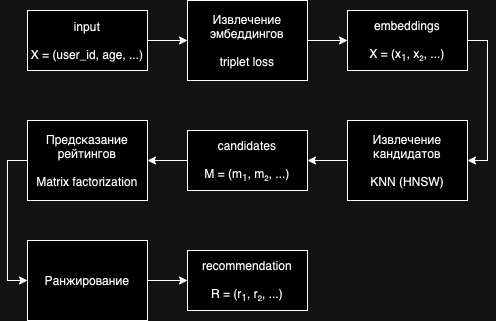

## Embedding retrieving

In [1]:
# Импорт билиотек
import pandas as pd
import numpy as np
import torch
import random
import hnswlib
from sklearn.preprocessing import StandardScaler

In [2]:
import pandas as pd

# Загрузка данных
ratings = pd.read_csv("ml-100k/u.data", sep='\t', header=None)
ratings.columns = ["user_id", "movie_id", "rating", "timestamp"]
ratings = ratings.drop(["timestamp"], axis=1)

movies = pd.read_csv("ml-100k/u.item", encoding='latin-1', header=None, sep='|')
movies.columns = ["movie_id", "movie_title", "release_date", "video_release_date",
              "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]
movies["release_date"] = pd.to_datetime(movies['release_date']).dt.year
movies = movies.drop(["IMDb_URL", "video_release_date", "movie_title"], axis=1)

# Объединение данных
data = pd.merge(ratings, movies, on='movie_id')

data.head()

,user_id,movie_id,rating,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,1997.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,1994.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,1994.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,1997.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def generate_triplets(data: pd.DataFrame):
    triplets = []

    grouped_data = data.groupby('user_id')
    for user_id, user_ratings in grouped_data:
        positive_items = user_ratings[user_ratings['rating'] >= 4]['movie_id'].to_list()
        negative_items = user_ratings[user_ratings['rating'] <= 2]['movie_id'].to_list()
    
    if len(positive_items) > 1 and len(negative_items) > 0:
        for anchor in positive_items:
            positive = random.choice(positive_items)
            negative = random.choice(negative_items)
            triplets.append((anchor, positive, negative))
    
    return triplets

In [4]:
class MovieEmbedding(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim=32):
        super(MovieEmbedding, self).__init__()

        # fc - fully connected layer
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, embedding_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class MovieTripletData(torch.utils.data.Dataset):
    def __init__(self, triplets, item_features):
        self.triplets = triplets
        self.item_features = item_features.set_index('movie_id')

    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, index):
        anchor, positive, negative = self.triplets[index]

        anchor_features = self.item_features.loc[anchor].values
        positive_features = self.item_features.loc[positive].values
        negative_features = self.item_features.loc[negative].values

        return (torch.tensor(anchor_features, dtype=torch.float32),
                torch.tensor(positive_features, dtype=torch.float32),
                torch.tensor(negative_features, dtype=torch.float32))

In [6]:
movies_features = movies[["movie_id", "release_date",
                "unknown", "Action", "Adventure", "Animation",
                "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                "Thriller", "War", "Western"]]

scaler = StandardScaler()
movies_features['release_date'] = scaler.fit_transform(movies_features[['release_date']])

input_dim = movies_features.shape[1] - 1 # -1 for movie_id
embedding_dim = 32
embedding_model = MovieEmbedding(input_dim=input_dim, embedding_dim=embedding_dim)

triplets = generate_triplets(data=data)
triplets_data = MovieTripletData(triplets=triplets, item_features=movies_features)
train_loader = torch.utils.data.DataLoader(triplets_data, batch_size=32, shuffle=True)

triplet_loss = torch.nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=0.001)

In [7]:
embedding_model.train()
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0
    for anchor, positive, negative in train_loader:
        anchor_embedding = embedding_model(anchor)
        positive_embedding = embedding_model(positive)
        negative_embedding = embedding_model(negative)

        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
loss

Epoch 1/100, Loss: 1.013134479522705
Epoch 2/100, Loss: 0.9697470664978027
Epoch 3/100, Loss: 0.8187940716743469
Epoch 4/100, Loss: 0.8777746558189392
Epoch 5/100, Loss: 0.7974900603294373
Epoch 6/100, Loss: 0.7622036933898926
Epoch 7/100, Loss: 0.7207441329956055
Epoch 8/100, Loss: 0.7907691597938538
Epoch 9/100, Loss: 0.6921727657318115
Epoch 10/100, Loss: 0.763102114200592
Epoch 11/100, Loss: 0.6567465662956238
Epoch 12/100, Loss: 0.6576946973800659
Epoch 13/100, Loss: 0.7160506844520569
Epoch 14/100, Loss: 0.6530037522315979
Epoch 15/100, Loss: 0.6408506035804749
Epoch 16/100, Loss: 0.5787281394004822
Epoch 17/100, Loss: 0.6134269833564758
Epoch 18/100, Loss: 0.5979869365692139
Epoch 19/100, Loss: 0.5684909820556641
Epoch 20/100, Loss: 0.4724176228046417
Epoch 21/100, Loss: 0.5793420076370239
Epoch 22/100, Loss: 0.5741892457008362
Epoch 23/100, Loss: 0.49601373076438904
Epoch 24/100, Loss: 0.4594266712665558
Epoch 25/100, Loss: 0.39590197801589966
Epoch 26/100, Loss: 0.565757751464

tensor(0.1468, grad_fn=<MeanBackward0>)

In [8]:
# Оценка модели построения эмбеддингов
positive_distances = []
negative_distances = []

embedding_model.eval()  # Выключаем режим тренировки
with torch.no_grad():
    for anchor, positive, negative in train_loader:
        anchor_embedding = embedding_model(anchor)
        positive_embedding = embedding_model(positive)
        negative_embedding = embedding_model(negative)

        pos_dist = torch.norm(anchor_embedding - positive_embedding, p=2, dim=1)
        neg_dist = torch.norm(anchor_embedding - negative_embedding, p=2, dim=1)

        positive_distances.extend(pos_dist.cpu().numpy())
        negative_distances.extend(neg_dist.cpu().numpy())

print(f"Average Positive Distance: {np.mean(positive_distances)}")
print(f"Average Negative Distance: {np.mean(negative_distances)}")

Average Positive Distance: 1.0582867860794067
Average Negative Distance: 2.215952157974243


In [9]:
def get_embedding(movie_id, movies_features):
    return embedding_model(torch.tensor(movies_features.set_index("movie_id").loc[movie_id].values, dtype=torch.float32))

In [10]:
def process_data_to_embedding(movies_features):
    embeddings = []
    for movie_id in movies_features["movie_id"]:
        embeddings.append(get_embedding(movie_id, movies_features).detach().numpy())
    return np.array(embeddings)

In [11]:
def set_hnsw(embeddings, embedding_dim, ef_construction=1000, M=200):
    num_elements = embeddings.shape[0]
    hnsw_index = hnswlib.Index(space='l2', dim=embedding_dim)
    hnsw_index.init_index(max_elements=num_elements, ef_construction=ef_construction, M=M)
    hnsw_index.add_items(embeddings)

    return hnsw_index

In [12]:
def query_hnsw_index(hnsw_index, item_id, k):
    labels, distances = hnsw_index.knn_query([get_embedding(item_id, movies_features).detach().numpy()], k=k)
    return labels[0], distances[0]

In [13]:
from sklearn.metrics.pairwise import cosine_similarity


def average_cosine_similarity(movie_embedding, nearest_embeddings):
    similarities = cosine_similarity([movie_embedding], nearest_embeddings)
    return similarities.mean()


embeddings = process_data_to_embedding(movies_features)
hnsw_index = set_hnsw(embeddings, 32)
movie_id = 30

avg = 0
count = 0
for id in movies_features["movie_id"][1:100]:
    near_movie_id, distances = query_hnsw_index(hnsw_index, id,  k=10)
    near_movie_id_emb = []
    for n_id in near_movie_id:
        near_movie_id_emb.append(get_embedding(n_id, movies_features).detach().numpy())
    avg += average_cosine_similarity(get_embedding(id, movies_features).detach().numpy(), near_movie_id_emb)
    count += 1
print(avg/count)


0.461003554853225


In [14]:
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
user_item_matrix = user_item_matrix.fillna(0)


user_item_tensor = torch.tensor(user_item_matrix.values, dtype=torch.float32)

n_users = user_item_tensor.shape[0]
n_items = user_item_tensor.shape[1]

print(n_users, n_items)
user_item_matrix

943 1682


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=32):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = torch.nn.Embedding(n_users, embedding_dim)
        self.items_embedding = torch.nn.Embedding(n_items, embedding_dim)

    def forward(self, user_ids, item_ids):
        user_factors = self.user_embedding(user_ids)
        item_factors = self.items_embedding(item_ids)

        return (user_factors * item_factors).sum(1)

In [17]:
user_ids, movie_ids = torch.where(user_item_tensor > 0)
ratings = user_item_tensor[user_ids, movie_ids]
print(ratings)
embedding_dim=32
MF_model = MatrixFactorization(n_users, n_items, embedding_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(MF_model.parameters(), lr=0.01)

epochs = 100

for epoch in range(epochs):
    MF_model.train()

    predicted_ratings = MF_model(user_ids, movie_ids)
    
    loss = criterion(predicted_ratings, ratings)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

tensor([5., 3., 4.,  ..., 3., 3., 3.])
Epoch 1/100, Loss: 45.904258728027344
Epoch 2/100, Loss: 44.67478561401367
Epoch 3/100, Loss: 43.48434829711914
Epoch 4/100, Loss: 42.33246994018555
Epoch 5/100, Loss: 41.21855545043945
Epoch 6/100, Loss: 40.14194107055664
Epoch 7/100, Loss: 39.10187911987305
Epoch 8/100, Loss: 38.09756851196289
Epoch 9/100, Loss: 37.12813949584961
Epoch 10/100, Loss: 36.19267654418945
Epoch 11/100, Loss: 35.29023742675781
Epoch 12/100, Loss: 34.41983413696289
Epoch 13/100, Loss: 33.5804557800293
Epoch 14/100, Loss: 32.771060943603516
Epoch 15/100, Loss: 31.990585327148438
Epoch 16/100, Loss: 31.237964630126953
Epoch 17/100, Loss: 30.512109756469727
Epoch 18/100, Loss: 29.81192970275879
Epoch 19/100, Loss: 29.136329650878906
Epoch 20/100, Loss: 28.484220504760742
Epoch 21/100, Loss: 27.854509353637695
Epoch 22/100, Loss: 27.246116638183594
Epoch 23/100, Loss: 26.6579647064209
Epoch 24/100, Loss: 26.088987350463867
Epoch 25/100, Loss: 25.538131713867188
Epoch 26/10

In [26]:
def recommend_movies_for_user(user_id, model, user_item_matrix, hnsw_index, movie_embeddings, k=10):    
    user_ratings = user_item_matrix.loc[:, user_id]
    rated_movies = user_ratings[user_ratings > 0].index.tolist()  # Фильмы, которые пользователь оценил
    
    recommended_movies = set()
    for movie_id in rated_movies:
        labels, distances = query_hnsw_index(hnsw_index, movie_id, k)
        recommended_movies.update(labels)
    
    recommended_movies = recommended_movies - set(rated_movies)  # Убираем фильмы, которые пользователь уже смотрел
    recommended_movies = list(recommended_movies)
    
    movie_ids = torch.tensor(recommended_movies, dtype=torch.long)
    user_ids = torch.tensor([user_id] * len(movie_ids))
    
    with torch.no_grad():
        predicted_ratings = model(user_ids, movie_ids)

    recommendations = list(zip(recommended_movies, predicted_ratings.numpy()))
    
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    return recommendations


In [27]:
# Пример работы функции
user_id = 42
movie_embeddings = process_data_to_embedding(movies_features)

recommended_movies = recommend_movies_for_user(user_id, MF_model, user_item_matrix, hnsw_index, movie_embeddings, k=10)

# Выводим результаты
for movie_id, rating in recommended_movies:
    print(f"Movie ID: {movie_id}, Predicted Rating: {rating}")

Movie ID: 424, Predicted Rating: 8.29802131652832
Movie ID: 278, Predicted Rating: 8.223139762878418
Movie ID: 681, Predicted Rating: 7.772442817687988
Movie ID: 151, Predicted Rating: 7.750059127807617
Movie ID: 649, Predicted Rating: 7.562234878540039
Movie ID: 1006, Predicted Rating: 7.410604476928711
Movie ID: 652, Predicted Rating: 7.1533002853393555
Movie ID: 794, Predicted Rating: 7.15218448638916
Movie ID: 994, Predicted Rating: 7.123983383178711
Movie ID: 1027, Predicted Rating: 7.062244892120361
Movie ID: 193, Predicted Rating: 6.90226936340332
Movie ID: 1274, Predicted Rating: 6.8182854652404785
Movie ID: 97, Predicted Rating: 6.755847930908203
Movie ID: 812, Predicted Rating: 6.748110771179199
Movie ID: 167, Predicted Rating: 6.514004230499268
Movie ID: 693, Predicted Rating: 6.513036251068115
Movie ID: 290, Predicted Rating: 6.43419075012207
Movie ID: 392, Predicted Rating: 6.401739120483398
Movie ID: 1571, Predicted Rating: 6.397868633270264
Movie ID: 312, Predicted Ratin